# Excercise 2

In this exercise, we will try out different threshold methods, see how they react to noisy data - and how filtering can help to improve the results

In [30]:
from skimage import data, filters, measure, util, morphology
import matplotlib.pyplot as plt
import napari
import numpy as np

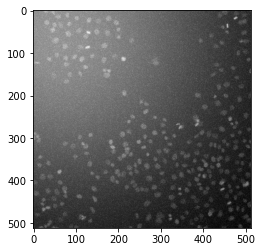

In [40]:
# First, we create some noisy data - don't modify this code section
image = data.human_mitosis()
noisy_data = util.random_noise(image, mode='gaussian') * 255  # this adds some local noisy
bg = np.zeros_like(noisy_data)
bg[50,50] = 255
bg_blur = filters.gaussian(bg, sigma=300)
bg_blur = 255*bg_blur/bg_blur.max()
noisy_data += bg_blur
plt.imshow(noisy_data, cmap='gray')  # adjust the values for vmin and vmax to get a better impression!

In order to clear the added noise to the raw image in variable `noisy_data`, you need to apply **noise removal** and **background subtraction**. Apply 

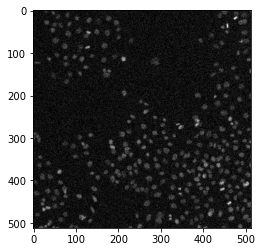

In [39]:
footprint = morphology.disk(7)
background = morphology.white_tophat(#Put the noisy image here)
plt.imshow(background, cmap='gray')  # adjust the values for vmin and vmax to get a better impression!

In [ ]:
# Code goes here

Now, apply several of the thresholds from `skimage` to the image data! Choose one that you think is suitable.
Hint: You can find them under `filters.threshold_...` - use the `tab` key or the [documentation](https://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=filters#module-skimage.filters) to find out how to use the implemented threshold functions.

In [ ]:
binary_image = # code goes here

Again, use `plt.imshow()` to visualize the results

In [ ]:
# Code goes here

Now we would like to perform connected-component analysis. Use the appropriate function from skimage (`measure.label()`) for this task!

In [ ]:
label_image = # code goes here

## Visualization in Napari

In [5]:
viewer = napari.Viewer()

Use the `add_image()` and the `add_labels()` function to add `image`, `binary_image` and `label_image` to the viewer and create screenshot of the viewer with the `napari.utils.nbscreenshot()` function.

In [8]:
# Code goes here